# **Análisis de Redes Sociales: Teoría y Práctica**

#### **Comunidades en Redes**

 Las comunidades en redes son grupos de nodos que están más densamente conectados entre sí que con el resto de la red. Son estructuras fundamentales que revelan la organización jerárquica y modular de sistemas complejos. Podemos encontrar ejemplos de estructuras comunitarias en diversos contextos:

 * Redes Sociales: Grupos de amigos, familias, compañeros de trabajo
 * Redes Biológicas: Grupos funcionales de proteínas, módulos metabólicos
 * Redes de Internet: Clusters de páginas web relacionadas temáticamente
 * Redes Organizacionales: Departamentos, equipos de trabajo

La identificación de estas comunidades nos permite:

 * Comprender la estructura organizativa del sistema
 * Identificar grupos funcionales
 * Predecir comportamientos y propiedades emergentes
 * Optimizar procesos y flujos de información

#### **Importancia en Análisis de Redes**

 La detección de comunidades es crucial porque:
 * Revela la estructura jerárquica natural de la red
 * Permite identificar subsistemas funcionales
 * Facilita el análisis de grandes redes al dividirlas en componentes más manejables
 * Ayuda a entender cómo se propaga la información o los recursos en la red

## **1. Estructura de Comunidades**

### **1.1 Roles de Nodos en Comunidades**

Los nodos en redes (por ejemplo redessociales) pueden clasificarse según su rol en la estructura de comunidades.

- **Roles Topológicos**
  * Hubs: nodos altamente conectados
  * Autoridades: nodos que reciben muchas conexiones
  * Puentes: nodos que conectan diferentes partes de la red

- **Roles Comunitarios**
  * Conectores: nodos con muchas conexiones entre comunidades
  * Líderes: nodos centrales dentro de sus comunidades
  * Periféricos: nodos con pocas conexiones

- **Roles Funcionales**
  * Mediadores: facilitan la comunicación entre grupos
  * Gatekeepers: controlan el flujo de información
  * Aislados: nodos con poca participación en la red

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from community import community_louvain
import pandas as pd
from itertools import combinations
from collections import defaultdict, Counter
from tqdm import tqdm
import random

In [ ]:
def create_community_network(n_communities=3, size_per_community=10,
                             p_within=0.7, p_between=0.05):
    """
    Crea una red con estructura comunitaria clara

    Parámetros:
    n_communities: número de comunidades
    size_per_community: tamaño de cada comunidad
    p_within: probabilidad de conexión dentro de comunidades
    p_between: probabilidad de conexión entre comunidades
    """
    # Creamos la red
    G = nx.Graph()

    # Añadimos nodos con atributos de comunidad
    for i in range(n_communities):
        for j in range(size_per_community):
            node_id = i * size_per_community + j
            G.add_node(node_id, true_community=i)

    # Añadimos enlaces dentro de comunidades
    for i in range(n_communities):
        nodes_in_comm = [i * size_per_community + j
                        for j in range(size_per_community)]
        for n1, n2 in combinations(nodes_in_comm, 2):
            if np.random.random() < p_within:
                G.add_edge(n1, n2)

    # Añadimos enlaces entre comunidades
    for i, j in combinations(range(n_communities), 2):
        nodes_comm_i = [i * size_per_community + k
                       for k in range(size_per_community)]
        nodes_comm_j = [j * size_per_community + k
                       for k in range(size_per_community)]
        for n1 in nodes_comm_i:
            for n2 in nodes_comm_j:
                if np.random.random() < p_between:
                    G.add_edge(n1, n2)

    return G

# Creamos una red modular
G = create_community_network()
pos = nx.spring_layout(G, k=1, iterations=50)

# Detectamos comunidades
communities = community_louvain.best_partition(G)

<ipython-input-3-f2aa0a74ad67>:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


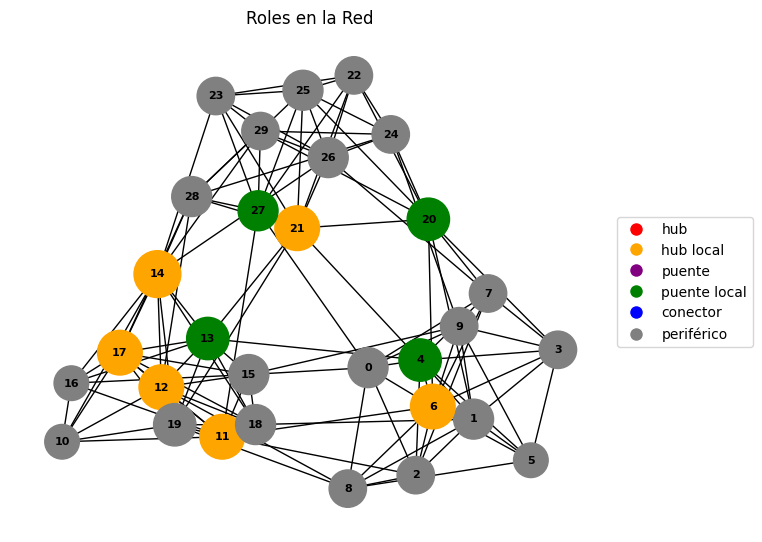

In [ ]:
def analyze_roles(G, communities):
    """
    Análisis completo de roles en la red
    """
    roles = {}
    metrics = {}

    # Calculamos métricas relevantes
    metrics['degree'] = nx.degree_centrality(G)
    metrics['betweenness'] = nx.betweenness_centrality(G)
    metrics['eigenvector'] = nx.eigenvector_centrality(G, max_iter=1000)

    # Calculamos métricas de participación entre comunidades
    participation = {}
    for node in G.nodes():
        # Contamos enlaces a diferentes comunidades
        neighbor_communities = set(communities[neigh]
                                 for neigh in G.neighbors(node))
        participation[node] = len(neighbor_communities)

    # Definimos umbrales para clasificación
    thresholds = {
        'degree': np.percentile(list(metrics['degree'].values()), 75),
        'betweenness': np.percentile(list(metrics['betweenness'].values()), 75),
        'participation': np.percentile(list(participation.values()), 75)
    }

    # Clasificamos roles
    for node in G.nodes():
        # Características base
        is_hub = metrics['degree'][node] > thresholds['degree']
        is_bridge = metrics['betweenness'][node] > thresholds['betweenness']
        is_connector = participation[node] > thresholds['participation']

        # Asignamos rol
        if is_hub:
            if is_connector:
                roles[node] = 'hub'
            else:
                roles[node] = 'hub local'
        elif is_bridge:
            if is_connector:
                roles[node] = 'puente'
            else:
                roles[node] = 'puente local'
        elif is_connector:
            roles[node] = 'conector'
        else:
            roles[node] = 'periférico'

    return roles, metrics, participation

# Analizamos los roles
roles, metrics, participation = analyze_roles(G, communities)

# Visualización de roles
plt.figure(figsize=(6, 5))
pos = nx.spring_layout(G)

# Colores por rol
color_map = {
    'hub': 'red',
    'hub local': 'orange',
    'puente': 'purple',
    'puente local': 'green',
    'conector': 'blue',
    'periférico': 'gray'
}

# Tamaños por grado
node_sizes = [3000 * metrics['degree'][node] for node in G.nodes()]
node_colors = [color_map[roles[node]] for node in G.nodes()]

nx.draw(G, pos, node_color=node_colors, node_size=node_sizes,
        with_labels=True, font_size=8, font_weight='bold')

# Leyenda
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                            markerfacecolor=color, label=role, markersize=10)
                  for role, color in color_map.items()]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Roles en la Red')
plt.tight_layout()
plt.show()

La imagen muestra un diagrama que representa una red de nodos interconectados con diferentes roles asignados según un código de colores:

- Nodos amarillos (14, 21, 6, 17, 11, 12): etiquetados como "hub local"
- Nodos verdes (27, 20, 13, 4): etiquetados como "puente local"
- Nodos grises (numerados como 23, 25, 22, 29, 24, 26, 28, 7, 9, 3, 0, 15, 1, 5, 2, 8, 18, 19, 10, 16): etiquetados como "periférico"

La leyenda también incluye categorías "hub" (rojo) y "puente" (morado), aunque no parecen estar presentes en esta visualización específica, y "conector" (azul) que tampoco aparece.

**Insights relevantes**

- Estructura jerárquica: La red muestra una organización jerárquica donde los hubs locales (amarillos) funcionan como centros de conexión que agrupan varios nodos periféricos.
- Puentes estratégicos: Los nodos verdes (puentes locales) parecen conectar diferentes clusters o comunidades dentro de la red, facilitando la comunicación entre grupos que de otra manera estarían más aislados.
- Densidad de conexiones: Hay zonas con mayor densidad de conexiones, particularmente alrededor de los nodos 21, 27 y 20, lo que sugiere áreas de mayor actividad o importancia.
- Nodo central: El nodo 0 parece tener una posición central en la estructura global de la red, conectando varias regiones diferentes.
- Resiliencia: La distribución de hubs locales y puentes sugiere que la red tiene redundancia en sus conexiones, lo que la haría más resistente a fallos en nodos individuales.
- Esta visualización sería útil para analizar patrones de comunicación, identificar puntos críticos de la red o planificar estrategias de optimización en sistemas de comunicación, redes sociales, o cualquier otro tipo de red donde las conexiones y roles de los nodos sean relevantes.

### **1.2 Modularidad**

 La modularidad (Q) es una medida que cuantifica la calidad de una partición de la red en comunidades. La modularidad es la métrica más utilizada para evaluar la calidad de las particiones en comunidades. Compara la densidad de enlaces dentro de las comunidades con la que se esperaría en una red aleatoria.

 $Q = \frac{1}{2m}\sum_{ij} \left(A_{ij} - \frac{k_i k_j}{2m}\right)\delta(c_i,c_j)$

 donde:
 - $A_{ij}$ es la matriz de adyacencia
 - $k_i, k_j$ son los grados de los nodos i, j
 - m es el número total de enlaces
 - $\delta(c_i,c_j)$ es 1 si i y j están en la misma comunidad, 0 en caso contrario

**Interpretación de la modularidad**

 * Q > 0.3: estructura comunitaria significativa
 * Q > 0.7: estructura comunitaria muy fuerte
 * Q ≈ 0: no hay estructura comunitaria clara

Crearemos una red simple con estructura comunitaria clara para entender el concepto.

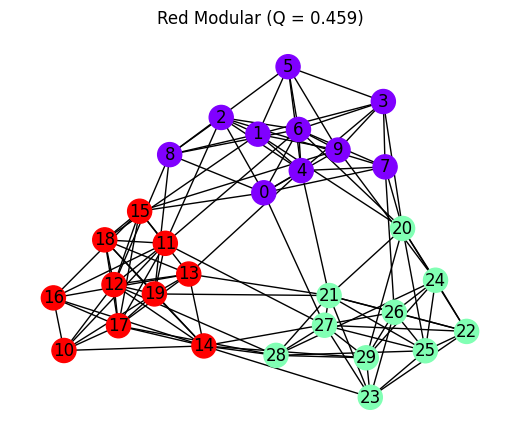

In [ ]:
# Calculamos modularidad
modularity = community_louvain.modularity(communities, G)

# Visualización
plt.figure(figsize=(5, 4))
pos = nx.spring_layout(G)
colors = [communities[node] for node in G.nodes()]
nx.draw(G, pos, node_color=colors,
        with_labels=True, cmap=plt.cm.rainbow)
plt.title(f'Red Modular (Q = {modularity:.3f})')
plt.show()

La imagen muestra un diagrama que representa una red de nodos interconectados dividida en tres comunidades claramente diferenciadas por colores:

- Comunidad roja (nodos 12, 13, 14, 15, 16, 17, 18, 19): forma un grupo densamente conectado en la parte izquierda
- Comunidad púrpura/morada (nodos 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10): ocupa la parte superior del diagrama
- Comunidad verde (nodos 20, 21, 22, 23, 24, 25, 26, 27, 28, 29): se ubica en la parte derecha e inferior

**Insights relevantes**

- Modularidad elevada: El valor Q = 0.459 indica una estructura modular significativa, lo que significa que los nodos dentro de cada comunidad están más conectados entre sí que con nodos de otras comunidades.
- Comunidades bien definidas: Las tres comunidades son claramente distinguibles, lo que sugiere que hay poca ambigüedad en la asignación de nodos a comunidades.
- Conexiones intercomunidades: Aunque las comunidades están bien definidas, existen conexiones entre ellas. Particularmente, los nodos 10 (morado), 12 (rojo) y 28 (verde) parecen funcionar como "puentes" o "intermediarios" entre diferentes comunidades.
- Distribución de conexiones: La comunidad roja muestra conexiones muy densas entre sus miembros, mientras que la comunidad verde parece tener una densidad de conexiones interna ligeramente menor.
- Estructura jerárquica: Dentro de cada comunidad, algunos nodos tienen más conexiones que otros, lo que sugiere una posible jerarquía o importancia diferencial dentro de cada grupo.
- El alto valor de modularidad (Q) sugiere que estas comunidades tienen un significado real en el contexto del sistema que representa la red, ya sea una red social, organizacional, biológica u otro tipo de sistema complejo.

#### **Resolución de Modularidad**

La modularidad tiene un "límite de resolución" que afecta el tamaño de las comunidades detectadas.

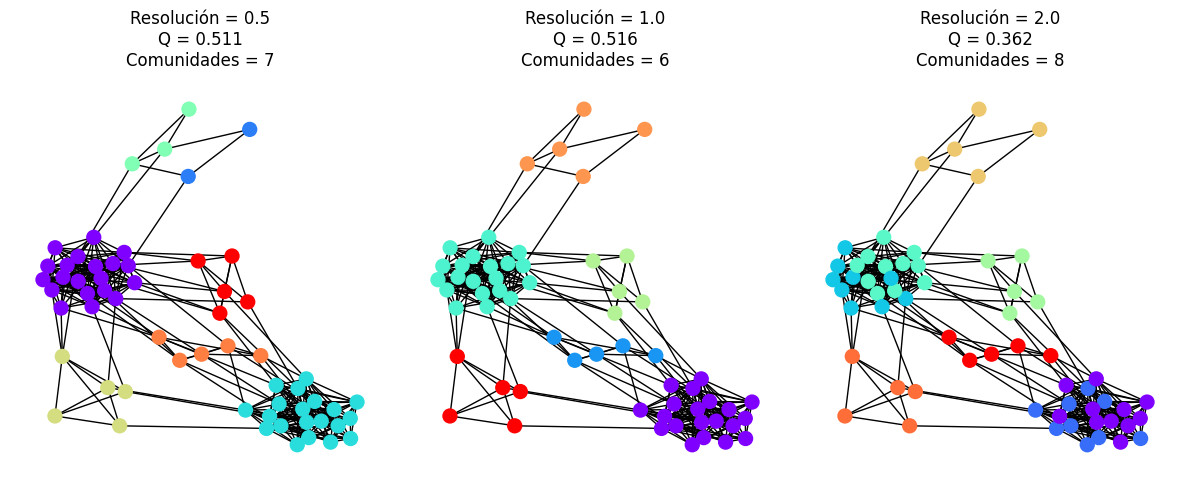

In [ ]:
def analyze_resolution_limit():
    """
    Demuestra el límite de resolución de la modularidad
    """
    # Creamos una red con comunidades de diferentes tamaños
    G = nx.Graph()

    # Añadimos dos comunidades grandes
    for i in range(2):
        for j in range(20):
            node_id = f'big_{i}_{j}'
            G.add_node(node_id, true_size='large')

    # Añadimos cuatro comunidades pequeñas
    for i in range(4):
        for j in range(5):
            node_id = f'small_{i}_{j}'
            G.add_node(node_id, true_size='small')

    # Conectamos nodos dentro de comunidades
    # Grandes comunidades
    for i in range(2):
        nodes = [f'big_{i}_{j}' for j in range(20)]
        for n1, n2 in combinations(nodes, 2):
            if np.random.random() < 0.7:
                G.add_edge(n1, n2)

    # Pequeñas comunidades
    for i in range(4):
        nodes = [f'small_{i}_{j}' for j in range(5)]
        for n1, n2 in combinations(nodes, 2):
            if np.random.random() < 0.7:
                G.add_edge(n1, n2)

    # Añadimos algunas conexiones entre comunidades
    for n1 in G.nodes():
        for n2 in G.nodes():
            if n1 < n2 and G.nodes[n1]['true_size'] != G.nodes[n2]['true_size']:
                if np.random.random() < 0.05:
                    G.add_edge(n1, n2)

    # Detectamos comunidades con diferentes resoluciones
    resolutions = [0.5, 1.0, 2.0]
    community_sets = {}

    for resolution in resolutions:
        communities = community_louvain.best_partition(G, resolution=resolution)
        community_sets[resolution] = communities

    # Visualización
    fig, axes = plt.subplots(1, len(resolutions), figsize=(12, 5))

    pos = nx.spring_layout(G)

    for i, (resolution, communities) in enumerate(community_sets.items()):
        colors = [communities[node] for node in G.nodes()]
        nx.draw(G, pos, node_color=colors,
               with_labels=False, node_size=100,
               cmap=plt.cm.rainbow, ax=axes[i])

        modularity = community_louvain.modularity(communities, G)
        n_communities = len(set(communities.values()))

        axes[i].set_title(f'Resolución = {resolution}\n'
                         f'Q = {modularity:.3f}\n'
                         f'Comunidades = {n_communities}')

    plt.tight_layout()
    plt.show()

    return community_sets

# Analizamos límite de resolución
community_sets = analyze_resolution_limit()

La imagen muestra tres representaciones de una misma red de nodos con diferentes resoluciones de detección de comunidades (0.5, 1.0 y 2.0).
Descripción de los tres diagramas:

- Resolución = 0.5 (izquierda):

  - Modulación Q = 0.511
  - 7 comunidades identificadas
  - Los nodos están agrupados en 7 colores distintos, con grupos de color morado y cian prominentes

- Resolución = 1.0 (centro):

  - Modulación Q = 0.516 (ligeramente mayor)
  - 6 comunidades identificadas
  - Redistribución de algunos nodos entre comunidades

- Resolución = 2.0 (derecha):

  - Modulación Q = 0.362 (menor)
  - 8 comunidades identificadas
  - Mayor fragmentación en algunas áreas, particularmente visible con los nodos rojos

**Insights relevantes**

- Efecto del parámetro de resolución:

  - La resolución actúa como un "zoom" en la estructura comunitaria. A mayor resolución (2.0), se detectan comunidades más pequeñas y fragmentadas, mientras que a menor resolución (0.5), se identifican comunidades más grandes y agregadas.

- Máxima modularidad a resolución intermedia:

  - El valor Q más alto (0.516) se observa a una resolución intermedia (1.0), sugiriendo que esta partición captura mejor la estructura natural de la red según el algoritmo de modularidad.

- Estabilidad de ciertas comunidades:

  - Algunos grupos de nodos permanecen unidos independientemente de la resolución (especialmente los grupos densos inferiores), lo que indica relaciones muy fuertes entre estos nodos.

- Nodos "fronterizos":

  - Ciertos nodos cambian de comunidad según la resolución, lo que sugiere que estos nodos tienen conexiones importantes con múltiples comunidades y podrían actuar como "puentes".

- Compromiso entre número y tamaño:

  - Existe un equilibrio entre tener pocas comunidades grandes (resolución baja) o muchas comunidades pequeñas (resolución alta). La elección de la resolución óptima depende del nivel de detalle requerido para el análisis.

- Este tipo de análisis multi-resolución es especialmente útil para comprender estructuras jerárquicas en redes complejas como redes sociales, biológicas, de transporte o de comunicación, ya que revela diferentes niveles de organización dentro del sistema.

 ### **1.3 Solapamiento de Comunidades**

 En redes reales, las comunidades a menudo tienden a solarse. Es decir, un nodo puede tener un mayor o menor grado de pertenencia a una u otra comunidad. El coeficiente de pertenencia de un nodo a una comunidad puede calcularse como:

 $\mu_{ic} = \frac{k_{ic}}{k_i}$

 donde:
 - $k_{ic}$ es el número de enlaces del nodo i a la comunidad c
 - $k_i$ es el grado total del nodo i

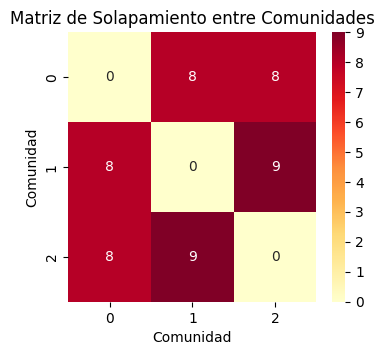

In [ ]:
def analyze_community_overlap(G, communities):
    # Calcular solapamiento entre comunidades
    overlap_matrix = np.zeros((max(communities.values()) + 1,
                               max(communities.values()) + 1))

    for edge in G.edges():
        c1 = communities[edge[0]]
        c2 = communities[edge[1]]
        if c1 != c2:
            overlap_matrix[c1][c2] += 1
            overlap_matrix[c2][c1] += 1

    # Visualizar matriz de solapamiento
    plt.figure(figsize=(4, 3.5))
    sns.heatmap(overlap_matrix, annot=True, cmap='YlOrRd')
    plt.title("Matriz de Solapamiento entre Comunidades")
    plt.xlabel("Comunidad")
    plt.ylabel("Comunidad")
    plt.show()

    return overlap_matrix

overlap_matrix = analyze_community_overlap(G, communities)

La imagen muestra una "Matriz de Solapamiento entre Comunidades" representada como un mapa de calor. Esta matriz tiene dimensiones 3x3, con comunidades etiquetadas de 0 a 2 tanto en el eje horizontal como vertical.

**Insights relevantes**

- Alto grado de solapamiento: Los valores entre 8 y 9 fuera de la diagonal indican un solapamiento muy significativo entre todas las comunidades.
- Simetría: La matriz es casi perfectamente simétrica, lo que indica que el solapamiento entre las comunidades A y B es similar al solapamiento entre B y - - A, como sería de esperar en una relación bidireccional.
- Máximo solapamiento: El solapamiento más fuerte (valor 9) se observa entre las comunidades 1 y 2 (en ambas direcciones).
- Estructura de red integrada: Este alto grado de solapamiento sugiere que, aunque existen comunidades distintas en la red, estas están fuertemente interconectadas, con muchos nodos o conexiones compartidas entre ellas.
- Desafío de particionamiento: Un solapamiento tan alto plantea desafíos para algoritmos de detección de comunidades tradicionales, que suelen buscar grupos más claramente separados.
- Esta matriz podría representar diversos tipos de redes donde las comunidades no son estrictamente separables, como redes sociales donde las personas pertenecen a múltiples grupos, redes biológicas con proteínas que participan en diferentes procesos, o redes de conocimiento donde los conceptos se comparten entre diferentes dominios.

### **1.4 Equivalencia Estructural**

 La equivalencia estructural es un concepto fundamental que identifica nodos que juegan roles similares en la red. Dos nodos son estructuralmente equivalentes si tienen exactamente los mismos patrones de conexiones con otros nodos.

- **Equivalencia Estructural Exacta**
 - Nodos con conexiones idénticas
 - Muy rara en redes reales

- **Equivalencia Regular**
 - Nodos conectados a nodos equivalentes
 - Más flexible que la equivalencia estructural

- **Equivalencia Automorfa**
 - Nodos que pueden intercambiarse preservando la estructura
 - Intermedia entre estructural y regular

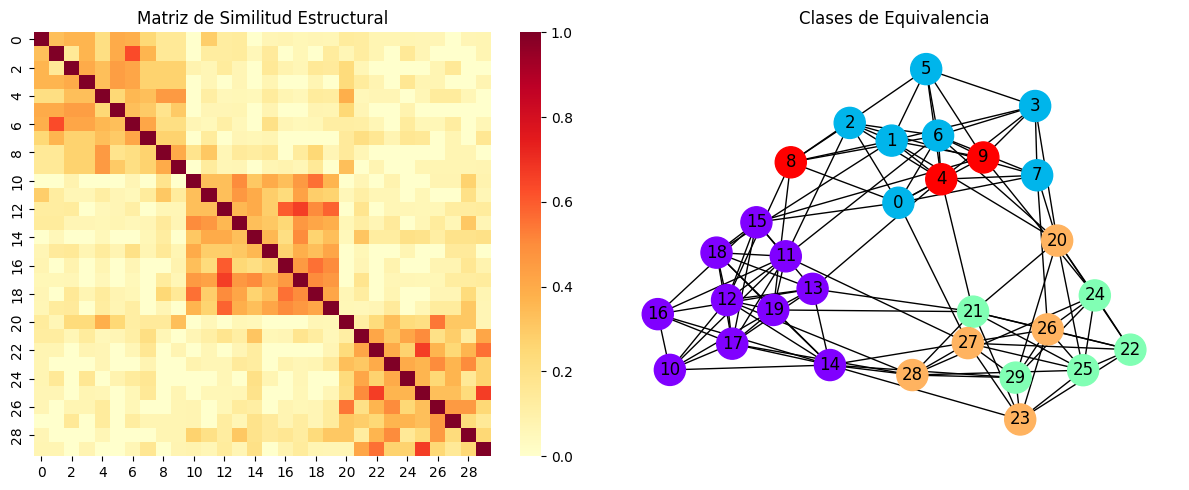

In [ ]:
def analyze_equivalence(G):
    """
    Análisis completo de equivalencia estructural
    """
    n = len(G)

    # Matriz de similitud estructural
    structural_sim = np.zeros((n, n))

    # Calculamos similitud para cada par de nodos
    for i in range(n):
        for j in range(n):
            # Conjuntos de vecinos
            neighbors_i = set(G.neighbors(i))
            neighbors_j = set(G.neighbors(j))

            # Similitud de Jaccard
            union = len(neighbors_i.union(neighbors_j))
            if union > 0:
                intersection = len(neighbors_i.intersection(neighbors_j))
                structural_sim[i,j] = intersection / union

    # Análisis de clustering basado en equivalencia
    from sklearn.cluster import SpectralClustering
    n_clusters = 5  # Número de grupos de equivalencia
    clustering = SpectralClustering(n_clusters=n_clusters,
                                  affinity='precomputed')
    equiv_classes = clustering.fit_predict(structural_sim)

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Matriz de similitud
    sns.heatmap(structural_sim, ax=ax1, cmap='YlOrRd')
    ax1.set_title('Matriz de Similitud Estructural')

    # Red con clases de equivalencia
    nx.draw(G, pos, node_color=equiv_classes,
           cmap=plt.cm.rainbow, node_size=500,
           with_labels=True, ax=ax2)
    ax2.set_title('Clases de Equivalencia')

    plt.tight_layout()
    plt.show()

    return structural_sim, equiv_classes

# Analizamos equivalencia estructural
structural_sim, equiv_classes = analyze_equivalence(G)

**Gráfico izquierdo - Matriz de Similitud Estructural**

- Es un mapa de calor que representa la similitud estructural entre 30 nodos (0-29)
- La diagonal principal muestra valores máximos (rojo oscuro = 1.0), indicando la similitud perfecta de cada nodo consigo mismo
- Se observan bloques de colores rojizos/anaranjados que indican grupos de nodos con alta similitud entre sí
- La escala de colores va de 0.0 (amarillo claro) a 1.0 (rojo oscuro)
- Se pueden distinguir aproximadamente 5-6 bloques de alta similitud a lo largo de la diagonal

**Gráfico derecha - Clases de Equivalencia**

- Muestra una representación visual de la red con nodos numerados del 0 al 29
Los nodos están coloreados por grupos que parecen corresponder a clases de equivalencia estructural:

- Azul claro: nodos 0, 1, 2, 3, 5, 6, 7
- Rojo: nodos 4, 8, 9
- Morado: nodos 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
- Naranja: nodos 20, 23, 26, 27, 28
- Verde claro: nodos 21, 22, 24, 25, 29

**Insights relevantes**

- Correspondencia entre visualizaciones: Los bloques de alta similitud en la matriz coinciden con los grupos de colores en el grafo, confirmando la estructura de clases de equivalencia.
- Roles estructurales: Los nodos del mismo color tienen posiciones estructuralmente similares en la red, lo que significa que comparten patrones de conexión similares con el resto de la red.
- Comunidades interconectadas: Se observa que hay conexiones entre diferentes clases de equivalencia, con algunos nodos que actúan como puentes (como el nodo 20 que conecta con múltiples grupos).
- Estructura jerárquica: La matriz muestra diferentes intensidades de similitud dentro y entre grupos, sugiriendo una jerarquía en la estructura de la red.
- Nodos centrales vs. periféricos: En el grafo, algunos nodos como el 1, 13 y 27 parecen tener roles más centrales con múltiples conexiones, mientras que otros como el 24 y 25 son más periféricos.
- Esta visualización permite identificar roles estructurales en la red que podrían no ser evidentes solo con la visualización de conexiones. Los nodos de la misma clase de equivalencia pueden cumplir funciones similares en el sistema, independientemente de su ubicación física en la red, lo que es especialmente útil para analizar redes sociales, organizacionales o biológicas complejas.

## **2. Detección de Comunidades**

### **2.1 Método de Louvain**
El método de Louvain es uno de los algoritmos más populares para la detección de comunidades debido a su eficiencia y efectividad. Este método trabaja en dos fases que se repiten iterativamente.

- **Optimización Local**
 * Cada nodo se asigna inicialmente a su propia comunidad
 * Para cada nodo i, se calcula el cambio en modularidad al moverlo a la comunidad de cada vecino
 * El nodo se mueve a la comunidad que produce el mayor incremento en modularidad

- **Agregación**
 * Se crea una nueva red donde los nodos son las comunidades encontradas
 * Los pesos de los enlaces entre nuevos nodos son la suma de los pesos entre comunidades

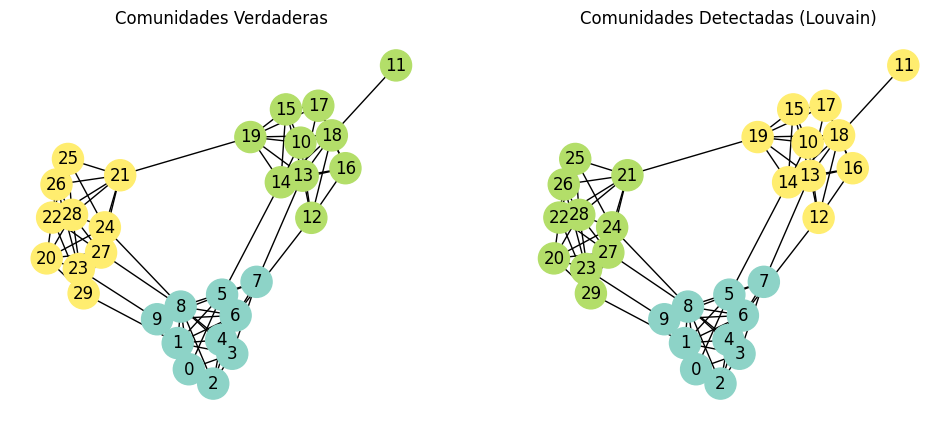

Análisis de la detección de comunidades:
Número de comunidades detectadas: 3
Modularidad de la partición: 0.579


In [ ]:
# Creamos y analizamos la red
G = create_community_network()

# Detectamos comunidades usando Louvain
# communities = community_louvain.best_partition(G)

# Visualización comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Visualizamos comunidades verdaderas
pos = nx.spring_layout(G)
true_colors = [G.nodes[node]['true_community'] for node in G.nodes()]
nx.draw(G, pos, node_color=true_colors, with_labels=True,
        node_size=500, cmap=plt.cm.Set3, ax=ax1)
ax1.set_title("Comunidades Verdaderas")

# Visualizamos comunidades detectadas
detected_colors = [communities[node] for node in G.nodes()]
nx.draw(G, pos, node_color=detected_colors, with_labels=True,
        node_size=500, cmap=plt.cm.Set3, ax=ax2)
ax2.set_title("Comunidades Detectadas (Louvain)")
plt.show()

# Análisis de resultados
modularity = community_louvain.modularity(communities, G)
n_communities_detected = len(set(communities.values()))

print(f"Análisis de la detección de comunidades:")
print(f"Número de comunidades detectadas: {n_communities_detected}")
print(f"Modularidad de la partición: {modularity:.3f}")

**Gráfico Izquierda - "Comunidades Verdaderas"**
- Muestra la estructura real o de referencia de las comunidades en la red.

**Gráfico Derecha - "Comunidades Detectadas (Louvain)"**
- Muestra las comunidades identificadas mediante el algoritmo de detección de comunidades Louvain.

En ambas visualizaciones, los nodos (numerados del 0 al 29) están agrupados en tres comunidades principales identificadas por colores:

- Comunidad turquesa/azul claro (nodos 0-9): ubicada en la parte inferior
- Comunidad verde (nodos 10-19): ubicada en la parte superior/central
- Comunidad amarilla (nodos 20-29): ubicada en la parte izquierda

**Insights relevantes**

- Alta precisión del algoritmo Louvain: La similitud entre ambas visualizaciones indica que el algoritmo Louvain ha logrado detectar las comunidades verdaderas con gran exactitud. Las diferencias son mínimas.
- Discrepancia en asignación de nodos: La principal diferencia visible es la asignación del nodo 12, que aparece en verde (comunidad central) en las "Comunidades Verdaderas" pero en amarillo en las "Comunidades Detectadas".
- Estructura de puentes: algunos nodos como el 21 y el 8 funcionan como puentes entre comunidades, conectando grupos que de otra manera estarían más separados.
- Densidad de conexiones internas: se observa que las conexiones son más densas dentro de cada comunidad que entre comunidades diferentes, lo que explica por qué el algoritmo Louvain puede identificarlas efectivamente.
- Validación de métodos: esta comparación sirve como validación del algoritmo Louvain para este conjunto de datos particular, demostrando su capacidad para recuperar la estructura comunitaria subyacente con solo un error mínimo.
- La alta coincidencia entre las comunidades verdaderas y las detectadas sugiere que el algoritmo Louvain es una herramienta confiable para la detección de comunidades en este tipo de redes.

### **2.2 Algoritmo de Girvan-Newman**

 El algoritmo de Girvan-Newman es un método divisivo que:

- Identifica enlaces que actúan como "puentes" entre comunidades
- Elimina estos enlaces progresivamente
- Revela la estructura comunitaria natural

Los pasos del algoritmos de resumen a continuación.

- **Cálculo de intermediación**
 - Para cada par de nodos, encontrar todos los caminos más cortos
 - Contar cuántas veces cada enlace aparece en estos caminos
 - Normalizar los conteos

- **Eliminación de enlaces**
 - Remover el enlace con mayor intermediación
 - Este proceso separa gradualmente las comunidades

- **Evaluación de la estructura**
 - En cada paso, evaluar la calidad de las comunidades
 - Usar métricas como modularidad para encontrar la mejor partición

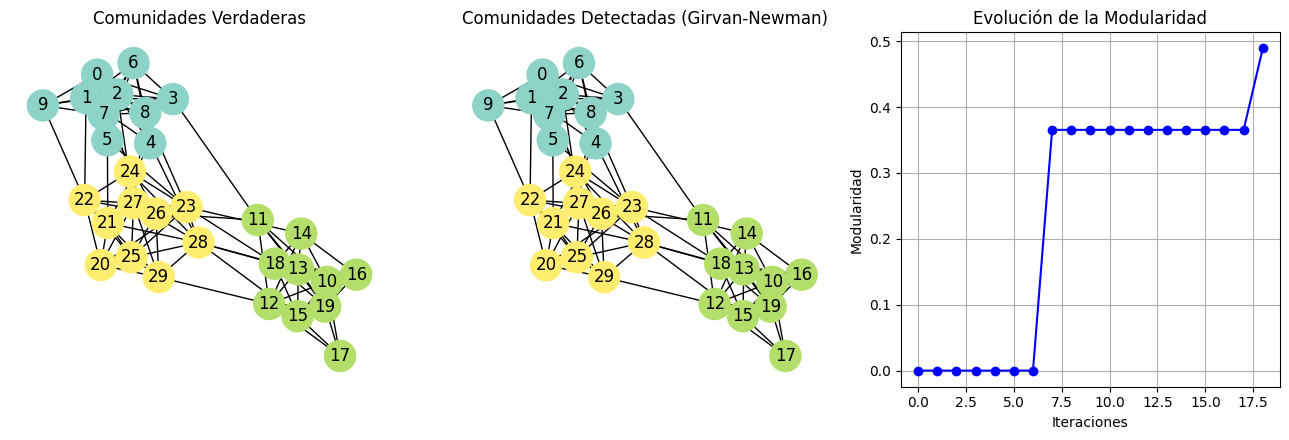


Análisis de la detección de comunidades:
Número de comunidades detectadas: 3
Modularidad de la partición: 0.489


In [ ]:
# Creamos y analizamos la red
G = create_community_network()

def girvan_newman_detection(G, k=None):
    """
    Implementa el algoritmo Girvan-Newman

    Parámetros:
    G: red NetworkX
    k: número deseado de comunidades
    """
    # Trabajamos con una copia
    G_copy = G.copy()

    # Lista para almacenar resultados
    modularity_scores = []
    community_sets = []

    def get_community_dict(components):
        """Convierte componentes en diccionario"""
        community_dict = {}
        for idx, community in enumerate(components):
            for node in community:
                community_dict[node] = idx
        return community_dict

    while G_copy.number_of_edges() > 0:
        # Calculamos edge betweenness
        edge_betweenness = nx.edge_betweenness_centrality(G_copy)

        # Encontramos la arista con mayor betweenness
        max_edge = max(edge_betweenness.items(), key=lambda x: x[1])[0]

        # Eliminamos la arista
        G_copy.remove_edge(*max_edge)

        # Obtenemos las componentes (comunidades)
        communities = list(nx.connected_components(G_copy))
        community_dict = get_community_dict(communities)

        # Calculamos modularidad
        modularity = community_louvain.modularity(community_dict, G)

        modularity_scores.append(modularity)
        community_sets.append(community_dict)

        # Si alcanzamos k comunidades, paramos
        if k is not None and len(communities) >= k:
            break

    # Encontramos la mejor partición
    best_idx = np.argmax(modularity_scores)
    best_communities = community_sets[best_idx]
    best_modularity = modularity_scores[best_idx]

    return best_communities, best_modularity, modularity_scores

# Creamos y analizamos la red
G = create_community_network()

# Detectamos comunidades usando Girvan-Newman
communities, modularity, modularity_history = girvan_newman_detection(G, k=3)

# Visualización comparativa
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4.5))

# Layout común para consistencia visual
pos = nx.spring_layout(G)

# Visualizamos comunidades verdaderas
true_colors = [G.nodes[node]['true_community'] for node in G.nodes()]
nx.draw(G, pos, node_color=true_colors, with_labels=True,
        node_size=500, cmap=plt.cm.Set3, ax=ax1)
ax1.set_title("Comunidades Verdaderas")

# Visualizamos comunidades detectadas por Girvan-Newman
detected_colors = [communities[node] for node in G.nodes()]
nx.draw(G, pos, node_color=detected_colors, with_labels=True,
        node_size=500, cmap=plt.cm.Set3, ax=ax2)
ax2.set_title("Comunidades Detectadas (Girvan-Newman)")

# Evolución de la modularidad
ax3.plot(modularity_history, 'b-', marker='o')
ax3.set_title("Evolución de la Modularidad")
ax3.set_xlabel("Iteraciones")
ax3.set_ylabel("Modularidad")
ax3.grid(True)

plt.tight_layout()
plt.show()

# Análisis de resultados
n_communities_detected = len(set(communities.values()))

print(f"\nAnálisis de la detección de comunidades:")
print(f"Número de comunidades detectadas: {n_communities_detected}")
print(f"Modularidad de la partición: {modularity:.3f}")

**Izquierda - "Comunidades Verdaderas":** muestra una red con 30 nodos (0-29) divididos en tres comunidades por colores:

  - Turquesa (nodos 0-9): grupo superior
  - Verde (nodos 10-19): grupo inferior derecho
  - Amarillo (nodos 20-29): grupo central/izquierdo

**Centro - "Comunidades Detectadas (Girvan-Newman)":** muestra los resultados del algoritmo Girvan-Newman aplicado a la misma red, con una distribución de comunidades idéntica a las comunidades verdaderas.

**Derecha - "Evolución de la Modularidad":** gráfico que muestra cómo evoluciona el valor de modularidad durante las iteraciones del algoritmo Girvan-Newman:

  - Permanece en 0 hasta la iteración 6
  - Salta a aproximadamente 0.36 en la iteración 7
  - Se mantiene estable hasta la iteración 17
  - Finalmente aumenta a casi 0.5 en la última iteración (17.5)

**Insights relevantes**

- Precisión perfecta del algoritmo: el algoritmo Girvan-Newman ha logrado identificar exactamente las mismas comunidades que las etiquetadas como "verdaderas", mostrando una eficacia del 100% en este caso particular.
- Salto de modularidad significativo: el gráfico de evolución muestra un momento crítico alrededor de la iteración 7, donde la modularidad pasa de 0 a 0.36, lo que sugiere que en ese punto el algoritmo identificó una división natural significativa en la red.
- Estructura de puentes: algunos nodos actúan como enlaces entre comunidades (como el nodo 11 conectando las comunidades verde y amarilla), lo que es importante para el flujo de información entre grupos.
- Densidad intracomunitaria vs. intercomunitaria: las conexiones son notablemente más densas dentro de cada comunidad que entre comunidades diferentes, lo que explica por qué el algoritmo puede detectarlas con tanta precisión.
- Optimización final: el último incremento en la modularidad (de 0.36 a 0.5) sugiere una optimización final en la detección de comunidades, posiblemente refinando los límites entre ellas.
- Validación metodológica: esta comparación demuestra que el algoritmo Girvan-Newman, que funciona eliminando progresivamente enlaces con alta intermediación (betweenness), es extremadamente efectivo para esta red en particular.
- Este tipo de análisis de comunidades es valioso en múltiples contextos, desde redes sociales hasta sistemas biológicos, ya que permite identificar grupos funcionales o estructurales que pueden tener comportamientos o propiedades similares dentro de sistemas complejos.

#### **Ejemplo Análisis Red Social**
Vamos a aplicar todos los conceptos aprendidos a un conjunto de datos real.Para este ejemplo, usaremos una subred de un conjunto de datos de red social.


Resumen del Análisis:
Número de nodos: 100
Número de enlaces: 243
Número de comunidades: 8

Distribución de roles:
hub local: 6 nodos (6.0%)
periférico: 64 nodos (64.0%)
puente local: 5 nodos (5.0%)
hub: 12 nodos (12.0%)
puente: 6 nodos (6.0%)
conector: 7 nodos (7.0%)


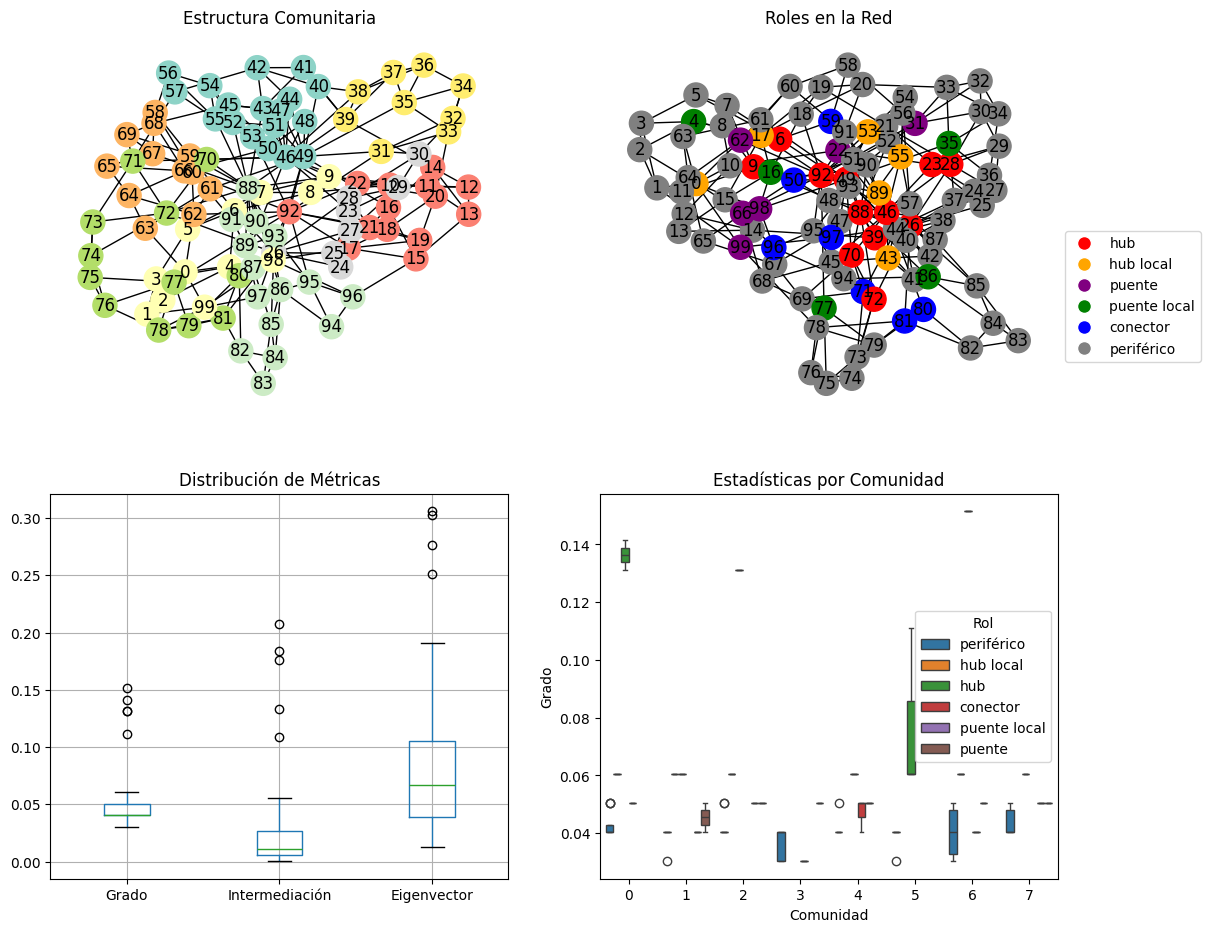

In [ ]:
def create_example_social_network():
    """
    Crea una red social sintética pero realista
    """
    # Creamos una red base con el modelo de Watts-Strogatz
    n_nodes = 100
    k = 4
    p = 0.1
    G = nx.watts_strogatz_graph(n_nodes, k, p)

    # Añadimos algunos hubs adicionales
    for i in range(5):
        node = random.randint(0, n_nodes-1)
        for _ in range(10):
            target = random.randint(0, n_nodes-1)
            if target != node:
                G.add_edge(node, target)

    return G

# Creamos y analizamos una red social de ejemplo
G_social = create_example_social_network()

# Análisis completo
results = {
    'communities': community_louvain.best_partition(G_social),
    'roles': None,
    'metrics': {}
}

# Añadimos roles y métricas
results['roles'], results['metrics'], participation = analyze_roles(G_social, results['communities'])

# Visualización final integrada
fig, axes = plt.subplots(2, 2, figsize=(13, 11))

# 1. Red con comunidades
colors_comm = [results['communities'][node] for node in G_social.nodes()]
nx.draw(G_social, pos=nx.spring_layout(G_social),
        node_color=colors_comm, with_labels=True,
        node_size=300, cmap=plt.cm.Set3, ax=axes[0,0])
axes[0,0].set_title("Estructura Comunitaria")

# 2. Red con roles
colors_roles = [color_map[results['roles'][node]] for node in G_social.nodes()]
nx.draw(G_social, pos=nx.spring_layout(G_social),
        node_color=colors_roles, with_labels=True,
        node_size=300, ax=axes[0,1])
axes[0,1].set_title("Roles en la Red")

# Colores por rol
color_map = {
    'hub': 'red',
    'hub local': 'orange',
    'puente': 'purple',
    'puente local': 'green',
    'conector': 'blue',
    'periférico': 'gray'
}

# Leyenda
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=color, label=role, markersize=10)
                   for role, color in color_map.items()]
axes[0,1].legend(handles=legend_elements, loc='best', bbox_to_anchor=(1, 0.5))

# 3. Distribución de métricas
metrics_df = pd.DataFrame({
    'Grado': list(results['metrics']['degree'].values()),
    'Intermediación': list(results['metrics']['betweenness'].values()),
    'Eigenvector': list(results['metrics']['eigenvector'].values())
})
metrics_df.boxplot(ax=axes[1,0])
axes[1,0].set_title("Distribución de Métricas")

# 4. Estadísticas por comunidad
community_stats = pd.DataFrame({
    'Comunidad': results['communities'].values(),
    'Rol': results['roles'].values(),
    'Grado': list(results['metrics']['degree'].values())
})
sns.boxplot(x='Comunidad', y='Grado', hue='Rol',
            data=community_stats, ax=axes[1,1])
axes[1,1].set_title("Estadísticas por Comunidad")

# Resumen estadístico
print("\nResumen del Análisis:")
print(f"Número de nodos: {len(G_social)}")
print(f"Número de enlaces: {G_social.number_of_edges()}")
print(f"Número de comunidades: {len(set(results['communities'].values()))}")
print("\nDistribución de roles:")
role_counts = Counter(results['roles'].values())
for role, count in role_counts.items():
    print(f"{role}: {count} nodos ({count/len(G_social)*100:.1f}%)")

**Estructura Comunitaria (arriba izquierda):**

- Visualización de la red con nodos agrupados por colores que representan diferentes comunidades.
- Se identifican al menos 6-7 comunidades distintas (amarilla, turquesa, naranja, verde claro, rojo, etc.).
- Los nodos están numerados del 0 al 97 aproximadamente.

**Roles en la Red (arriba derecha):**

- La misma red pero con nodos coloreados según sus roles funcionales:

  - Rojo: hubs (centros principales)
  - Naranja: hubs locales
  - orado: puentes
  - Verde: puentes locales
  - Azul: conectores
  - Gris: periféricos

**Distribución de Métricas (abajo izquierda):**

- Gráfico de cajas que muestra la distribución de tres métricas centrales:
  - Grado: número de conexiones por nodo
  - Intermediación: capacidad de un nodo para conectar diferentes partes de la red
  - Eigenvector: influencia de un nodo en la red
  - Muestra valores atípicos (outliers) especialmente en la métrica de eigenvector.


**Estadísticas por Comunidad (abajo derecha):**

- Gráfico que muestra métricas por cada comunidad (0-7)
- Las métricas están desagregadas por el rol de los nodos
- Destaca la comunidad 1 con valores más altos, particularmente en nodos periféricos.

**Insights relevantes**

- Estructura de centro-periferia: La red muestra una clara estructura donde unos pocos nodos centrales (hubs y hubs locales) concentran muchas conexiones, mientras la mayoría de nodos son periféricos con pocas conexiones.
- Correlación entre roles y métricas: Los roles asignados (hub, puente, conector) corresponden con las métricas de centralidad, donde los hubs tienen alto grado y eigenvector, mientras los puentes tienen alta intermediación.
- Comunidades interconectadas: Aunque existen comunidades bien definidas, hay una significativa interconexión entre ellas a través de nodos puente y conectores (morados y azules), fundamentales para la cohesión global de la red.
- Variabilidad entre comunidades: La comunidad 1 muestra características distintas con valores promedio más altos en varias métricas, sugiriendo que podría ser un grupo más influyente o central en la red general.
- Distribución asimétrica de métricas: El gráfico de distribución muestra que las tres métricas tienen distribuciones asimétricas, con muchos valores bajos y pocos muy altos, típico de redes de escala libre donde la influencia se concentra en pocos nodos.
- Esta visualización completa es extremadamente valiosa para entender tanto la estructura modular de la red (comunidades) como los roles funcionales de los nodos dentro del sistema, y podría aplicarse al análisis de redes sociales, organizacionales, biológicas o de transporte.

## **3. Casos Prácticos**

En esta sección exploraremos diferentes ejemplos de casos de prácticos que demuestran la aplicación práctica del análisis de redes en situaciones reales.  La identificación de usuarios influyentes (influencers) y comunidades es crucial para:
 - Marketing viral
 - Gestión de crisis
 - Campañas de información
 - Detección de desinformación

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from community import community_louvain
from sklearn.preprocessing import normalize
import random
import warnings
warnings.filterwarnings('ignore')

### **3.1 Análisis de Redes Sociales**

Este caso de estudio simula una plataforma tipo red social.

#### **Características de la red social simulada**

* Escala: red de tamaño medio (~1000 usuarios, corresponden a los nodos)
* Temporalidad: 30 días de actividad
* Interacciones: like, comment, share (corresponden a las conexiones)
* Atributos: información de usuario y comportamiento

#### **Objetivos del Análisis**
* Identificar patrones estructurales en la red
* Descubrir usuarios influyentes y su impacto
* Estudiar la formación de comunidades

#### **Metodología**

Analizaremos dos niveles con base en las métricas revisadas y la identificación de comunidades.

* Análisis Estructural
  - Métricas centralidad
  - Métricas estructurales

* Análisis de Usuario
  - Perfiles de comportamiento
  - Métricas de influencia
  - Roles en la red

In [ ]:
def create_social_network_data(n_users=1000, n_days=30):
    """
    Crea datos simulados de una red social
    """
    # Generamos red base usando Barabási-Albert para simular preferential attachment
    G = nx.barabasi_albert_graph(n_users, 5)

    # Añadimos atributos a los usuarios
    user_data = {}
    interaction_data = []

    for node in G.nodes():
        # Atributos de usuario
        user_data[node] = {
            'joins_date': datetime(2023, 1, 1) + pd.Timedelta(days=np.random.randint(0, 30)),
            'activity_level': np.random.choice(['high', 'medium', 'low'], p=[0.2, 0.5, 0.3]),
            'posts': np.random.poisson(10)
        }

        # Generamos interacciones
        for neighbor in G.neighbors(node):
            n_interactions = np.random.poisson(5)
            for _ in range(n_interactions):
                day = np.random.randint(0, n_days)
                interaction_data.append({
                    'source': node,
                    'target': neighbor,
                    'type': np.random.choice(['like', 'comment', 'share'], p=[0.7, 0.2, 0.1]),
                    'day': day,
                    'weight': np.random.randint(1, 5)
                })

    return G, pd.DataFrame(user_data).T, pd.DataFrame(interaction_data)

In [ ]:
# Generamos datos simulados
G_social, user_df, interaction_df = create_social_network_data()

# Análisis básico de la red
print("Estadísticas básicas de la red:")
print(f"Número de usuarios: {G_social.number_of_nodes()}")
print(f"Número de conexiones: {G_social.number_of_edges()}")

Estadísticas básicas de la red:
Número de usuarios: 1000
Número de conexiones: 4975


#### **3.1.1 Identificación de Influencers**

 Los influencers son usuarios clave que tienen un impacto significativo en la red. Podemos identificarlos usando diferentes métricas:

- Centralidad de grado: número directo de interacciones
- Centralidad de eigenvector: influencia basada en interacciones
- Centralidad de intermediación (betweenness): influencia basada en permitir interacciones
- PageRank: importancia recursiva
- Score influencer: promedio de los anteriores

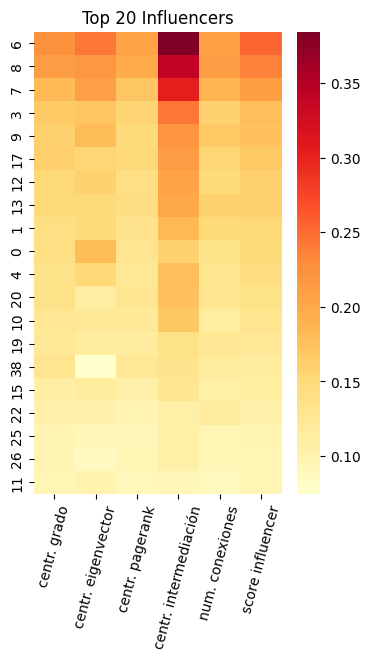

In [ ]:
def analyze_influencers(G, interaction_df):
    """
    Análisis completo de influencers usando múltiples métricas
    """
    # Calculamos diferentes medidas de centralidad
    metrics = {
        'centr. grado': nx.degree_centrality(G),
        'centr. eigenvector': nx.eigenvector_centrality_numpy(G),
        'centr. pagerank': nx.pagerank(G),
        'centr. intermediación': nx.betweenness_centrality(G)
    }

    # Creamos DataFrame con métricas
    influencer_df = pd.DataFrame(metrics)

    # Añadimos métricas de interacción
    interaction_metrics = interaction_df.groupby('source').agg({
        'target': 'count'
    }).rename(columns={'target': 'num. conexiones'})

    influencer_df = influencer_df.join(interaction_metrics)

    # Normalizamos todas las columnas
    influencer_df = pd.DataFrame(normalize(influencer_df, axis=0),
                                 index=influencer_df.index,
                                 columns=influencer_df.columns)

    # Calculamos score compuesto
    influencer_df['score influencer'] = influencer_df.mean(axis=1)

    return influencer_df

# Analizamos influencers
influencer_df = analyze_influencers(G_social, interaction_df)

# Visualización de top influencers
plt.figure(figsize=(4, 6))
top_influencers = influencer_df.nlargest(20, 'score influencer')
sns.heatmap(top_influencers, cmap='YlOrRd')
plt.title('Top 20 Influencers')
plt.xticks(rotation=75)
plt.show()

La imagen muestra un mapa de calor que visualiza diferentes métricas de centralidad para los 20 actores más influyentes en una red.

- El eje vertical muestra los nodos (identificados por números del 0 al 38, aunque solo se muestran los 20 principales)
- El eje horizontal muestra seis métricas de centralidad diferentes:

  - centr_grado (centralidad de grado)
  - centr_eigenvector (centralidad de vector propio)
  - centr_pagerank (valor de PageRank)
  - centr_intermediación (centralidad de intermediación)
  - num_conexiones (número de conexiones)
  - score_influencer (puntuación como influencer)

La intensidad del color va del amarillo claro (valores bajos ~0.08) al rojo oscuro (valores altos ~0.35), según la escala a la derecha.

**Insights relevantes**

- Dominancia del nodo 8: El nodo 8 destaca claramente con los valores más altos (rojo oscuro) en intermediación, indicando que es crucial para conectar diferentes partes de la red.

N- odos de alta influencia general: Los nodos 6, 7, 8 y 3 ocupan las primeras posiciones y muestran valores elevados en múltiples métricas, lo que sugiere que son influenciadores multidimensionales.

- Diferentes tipos de influenciadores: Se pueden identificar patrones distintos:

  - Nodos como el 6 y 7 tienen valores altos en todas las métricas
  - El nodo 8 destaca en intermediación pero es moderado en otras métricas
  - Algunos nodos (como 9, 17, 12) tienen una influencia moderada pero consistente

- Correlación entre métricas: Las métricas de centralidad de grado, eigenvector y número de conexiones parecen estar correlacionadas (patrones de color similares), mientras que la intermediación muestra un patrón distinto.

- Distribución desigual de la influencia: Los primeros 5-7 nodos concentran valores significativamente más altos que el resto, demostrando la típica distribución de poder en redes sociales donde pocos actores concentran la mayoría de la influencia.

- Diferentes dimensiones de influencia: Algunos nodos pueden tener un valor alto en una métrica pero bajo en otras, lo que sugiere roles especializados en la red:

  - Intermediarios (alto en intermediación)
  - Conectores locales (alto en grado)
  - Influenciadores por prestigio (alto en eigenvector/pagerank)

- Este tipo de análisis es valioso para identificar los actores clave en una red y entender qué tipo de influencia ejercen, lo que puede aplicarse en marketing de influencers, análisis organizacional, difusión de información o intervenciones estratégicas en la red.

#### **Insights Relevantes**

El análisis de influencers revela diferentes tipos de usuarios clave.

- **Hubs de conectividad** (alta centralidad de grado)
    - Funcionan como puntos de conexión
    - Alta visibilidad en la red
    - Potencial para alcance directo

- **Influencers estructurales** (alto PageRank)
    - Influencia basada en calidad de conexiones
    - Impacto en flujos de información
    - Roles estratégicos en la red

- **Puentes** (alta intermediación)
    - Conectan diferentes grupos
    - Crucial para difusión
    - Control de flujo de información

- **Lideres de engagement** (alta interacción - eigenvector)
    - Generan más engagement
    - Interacciones de calidad
    - Impacto en actividad de red

#### **3.1.2 Patrones de Interacción**

Estudiamos cómo los usuarios interactúan entre si dentro de la esructura de la red.

- Tipos de interacción: que tipos de interacciones son predominantes
- Densidad: el numero de interacciones existentes respecto al máximo posible de interacciones
- Reciprocidad: tendencia a presentar interacciones mutuas
- Transitividad: la probabilidad de que "los amigos de mis amigos son mis amigos"
- Clustering: tendencia a formar grupos con interacciones con amigos cercanos


Métricas de la Red:
Reciprocidad: 99.49%
Transitividad global: 2.87%
Densidad de la red: 0.99%
Coeficiente de clustering promedio: 3.69%


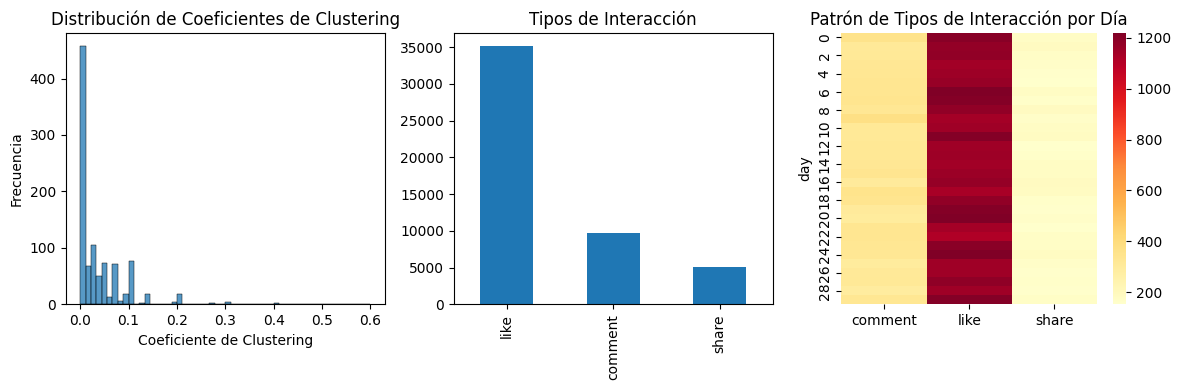

In [ ]:
def analyze_interaction_patterns(interaction_df):
    """
    Análisis detallado de patrones de interacción incluyendo densidad y clustering
    """
    # Análisis temporal
    temporal_patterns = interaction_df.groupby('day').size()

    # Análisis por tipo de interacción
    interaction_types = interaction_df['type'].value_counts()

    # Creamos el grafo de interacciones
    G_interactions = nx.DiGraph()
    for _, row in interaction_df.iterrows():
        G_interactions.add_edge(row['source'], row['target'], weight=row['weight'])

    # Análisis de reciprocidad
    interaction_pairs = set(map(tuple, interaction_df[['source', 'target']].values))
    reciprocal_pairs = set(tuple(reversed(p)) for p in interaction_pairs)
    reciprocity = len(interaction_pairs & reciprocal_pairs) / len(interaction_pairs)

    # Análisis de transitividad
    transitivity_global = nx.transitivity(G_interactions)

    # Análisis de densidad
    density = nx.density(G_interactions)

    # Análisis de clustering
    clustering_coefficient = nx.average_clustering(G_interactions)
    clustering_by_node = nx.clustering(G_interactions)

    # Imprimimos métricas
    print("\nMétricas de la Red:")
    print(f"Reciprocidad: {reciprocity:.2%}")
    print(f"Transitividad global: {transitivity_global:.2%}")
    print(f"Densidad de la red: {density:.2%}")
    print(f"Coeficiente de clustering promedio: {clustering_coefficient:.2%}")

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Distribución de coeficientes de clustering
    sns.histplot(data=list(clustering_by_node.values()), ax=axes[0])
    axes[0].set_title('Distribución de Coeficientes de Clustering')
    axes[0].set_xlabel('Coeficiente de Clustering')
    axes[0].set_ylabel('Frecuencia')

    # Tipos de interacción
    interaction_types.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Tipos de Interacción')
    axes[1].set_xlabel('')

    # Heatmap de interacciones por día y tipo
    interaction_pivot = pd.crosstab(interaction_df['day'], interaction_df['type'])
    sns.heatmap(interaction_pivot, ax=axes[2], cmap='YlOrRd')
    axes[2].set_title('Patrón de Tipos de Interacción por Día')
    axes[2].set_xlabel('')

    plt.tight_layout()
    plt.show()

# Analizamos patrones
analyze_interaction_patterns(interaction_df)

#### **Insights Relevantes**

El estudio de interacciones revela patrones significativos.

- **Densidad**:
  - Niveles muy bajos
  - Indica una red dispersa y extensa con conexiones selectivas
  - Típico de una red social grande

- **Reciprocidad**:
  - Niveles altos
  - Indica gran cantidad de interacciones mutuas
  - Típico en redes con varios grupos de amigos cercanos

- **Transitividad**
  - Nieveles muy bajos
  - Pocos enalces del tipo "los amigos de mis amigos son mis amigos"

- **Coeficiente de clustering**
  - En promedio niveles muy bajos
  - En promedio muestra poca tendencia a formar grupos locales de usuarios
  - La distribución muestra niveles muy bajos
  - La distribución indica poca tendencia a formar grupos locales de usuarios

- **Tipos de Interacción**
  - Predominio de interacciones ligeras (likes)
  - Se mantiene el predominio de interacciones ligeras en el tiempo

#### **3.1.3 Análisis de Comunidades**

 Las comunidades en redes sociales representan grupos de usuarios que interactúan más entre sí que con el resto de la red. El análisis incluye:

- Detección de comunidades
- Caracterización de comunidades
- Interacciones inter e intra comunidad
- Roles dentro de las comunidades

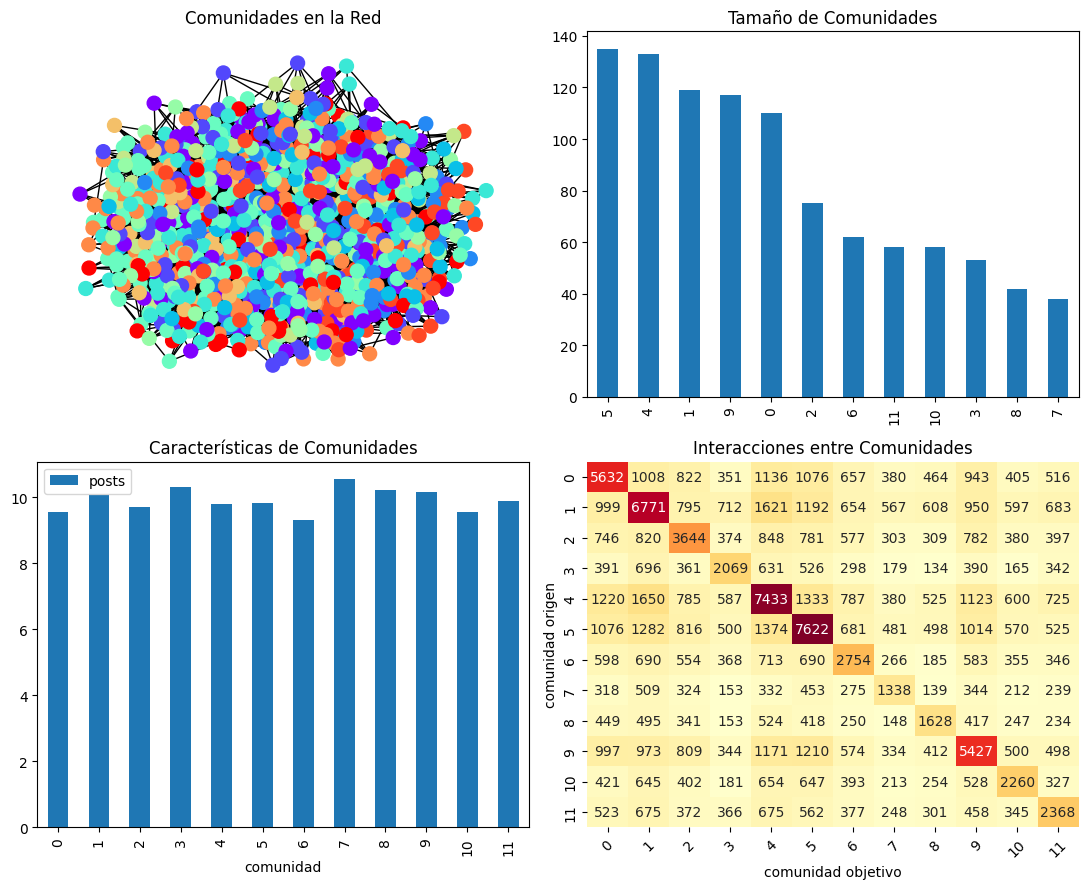

In [ ]:
def analyze_communities(G, interaction_df, user_df):
    """
    Análisis completo de estructura comunitaria
    """
    # Detectamos comunidades usando el método Louvain
    communities = community_louvain.best_partition(G)

    # Añadimos información de comunidad
    user_df['comunidad'] = pd.Series(communities)

    # Análisis de comunidades
    community_stats = user_df.groupby('comunidad').agg({
        'activity_level': lambda x: x.value_counts().index[0],
        'posts': 'mean'
    })

    # Análisis de interacciones entre comunidades
    interaction_df['comunidad origen'] = interaction_df['source'].map(communities)
    interaction_df['comunidad objetivo'] = interaction_df['target'].map(communities)

    # Matriz de interacciones entre comunidades
    community_interactions = pd.crosstab(
        interaction_df['comunidad origen'],
        interaction_df['comunidad objetivo'],
        values=interaction_df['weight'],
        aggfunc='sum'
    ).fillna(0)

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(11, 9))

    # Red con comunidades
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color=list(communities.values()),
            node_size=100, cmap=plt.cm.rainbow,
            ax=axes[0,0])
    axes[0,0].set_title('Comunidades en la Red')

    # Tamaño de comunidades
    community_sizes = pd.Series(communities).value_counts()
    community_sizes.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Tamaño de Comunidades')

    # Estadísticas por comunidad
    community_stats.plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Características de Comunidades')
    plt.xticks(rotation=45)

    # Interacciones entre comunidades
    sns.heatmap(community_interactions, ax=axes[1,1],
                cmap='YlOrRd', annot=True, fmt='.0f', cbar=False)
    axes[1,1].set_title('Interacciones entre Comunidades')

    plt.tight_layout()
    plt.show()

    return communities, community_stats

# Analizamos comunidades
communities, community_stats = analyze_communities(G_social, interaction_df, user_df)

**Comunidades en la Red (arriba izquierda)**

- Visualización gráfica de la red con nodos coloreados según su pertenencia a las diversas comunidades (aproximadamente 12 comunidades en diferentes colores)
- La red muestra una estructura muy densa e interconectada con cientos de nodos

**Tamaño de Comunidades (arriba derecha)**

- Gráfico de barras que muestra el número de miembros en cada comunidad
- Las comunidades 5 y 4 son las más grandes (~135 miembros cada una)
- Se observa una distribución decreciente con comunidades más pequeñas hacia la derecha

**Características de Comunidades (abajo izquierda)**

- Gráfico de barras que muestra la actividad promedio (posts) por comunidad
- Todas las comunidades muestran niveles similares de actividad (~9-10 posts por miembro)
- La comunidad 7 muestra la mayor actividad, seguida por la 3

**Interacciones entre Comunidades (abajo derecha)**

- Mapa de calor que muestra la frecuencia de interacciones entre comunidades
- Los valores en la diagonal (interacciones dentro de la misma comunidad) son generalmente los más altos
- Se muestran valores numéricos exactos de interacciones entre cada par de comunidades

**Insights relevantes**

- Estructura de comunidades equilibrada: Aunque existe variación en el tamaño, la red muestra una distribución relativamente equilibrada entre comunidades grandes y pequeñas, sin que una sola comunidad domine completamente.
- Homogeneidad en la actividad: A pesar de las diferencias de tamaño, todas las comunidades mantienen niveles similares de actividad por miembro (posts), lo que sugiere una participación consistente en toda la red.
- Interacción preferencial interna: La diagonal del mapa de calor muestra valores más altos, confirmando que los usuarios tienden a interactuar más dentro de su propia comunidad que con miembros de otras comunidades (homofilia).
- Comunidades altamente conectadas: A pesar de la preferencia por interacciones internas, hay un número significativo de interacciones entre diferentes comunidades, indicando una red bien integrada sin "silos" completamente aislados.
- Comunidades puente: Algunas comunidades (como la 4 y la 1) muestran altos niveles de interacción con varias otras comunidades, sugiriendo que funcionan como "puentes" o conectores en la red general.
- Relaciones asimétricas: algunas relaciones entre comunidades son asimétricas. Por ejemplo, la comunidad 0 tiene 1008 interacciones hacia la comunidad 1, pero recibe 999 de ésta, mostrando pequeños desequilibrios en la dirección de las interacciones.
- Alta densidad global: la visualización de la red muestra una estructura muy densa, lo que indica un alto nivel de cohesión general y sugiere una comunidad activa con múltiples puntos de interacción entre grupos.
- Esta información sería invaluable para administradores de plataformas, moderadores de comunidades o especialistas en marketing para entender la estructura de la comunidad, identificar influenciadores por grupo, y desarrollar estrategias dirigidas a segmentos específicos o para mejorar la cohesión entre determinadas comunidades.

#### **Roles en la Comunidad**

Para determinar los roles en las comunidades utilizaremos las siguientes metricas: centralidad de grado, intermediación, eigenvector, pagerank y el coeficiente de clustering. Para todas las métricas se aplica como umbral de separación el percentil 90. Con base a este umbral se deferencian los roles principales de los usuarios comunes. En la práctica este umbral puede tomar cualquier valor de acuerdo a las resultados esperados del análisis realizado. Para este ejemplo los roles definidos fueron:

- **Hub conectividad**: alta centralidad de grado y alto coeficiente de clustering
- **Influencer**: alta centralidad PageRank y alta centralidad eigenvector
- **Puente**: alta centralidad de intermediación y bajo coeficiente de clustering
- **Lider engagement**: alta centralidad de grado y alta centralidad PageRank


Estadísticas de Roles:

Influencer:
Número de nodos: 18
Métricas promedio:
- degree: 0.151
- pagerank: 0.014
- betweenness: 0.046
- eigenvector: 0.168
- clustering: 0.095

Lider Engagement:
Número de nodos: 20
Métricas promedio:
- degree: 0.145
- pagerank: 0.013
- betweenness: 0.043
- eigenvector: 0.160
- clustering: 0.095

Puente:
Número de nodos: 12
Métricas promedio:
- degree: 0.147
- pagerank: 0.014
- betweenness: 0.046
- eigenvector: 0.152
- clustering: 0.072

Superposición de Roles:
Influencer ∩ Lider engagement: 18 nodos
Influencer ∩ Puente: 10 nodos
Lider engagement ∩ Puente: 11 nodos


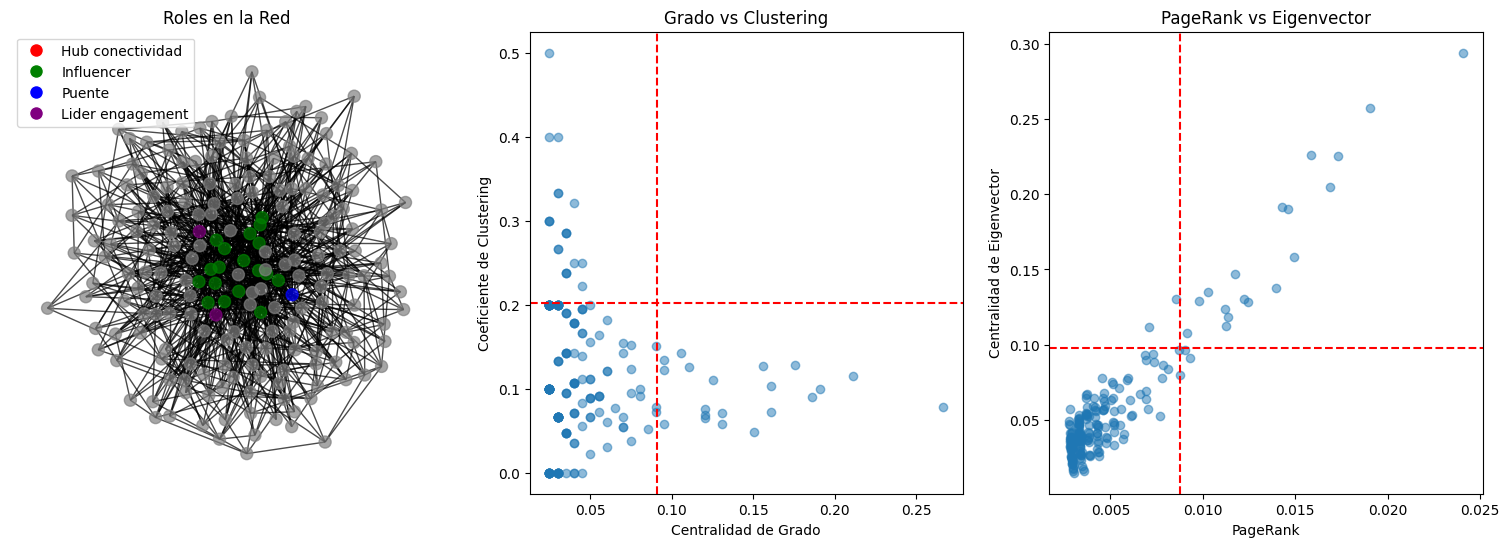

In [ ]:
def analyze_network_roles(G, percentile_threshold=90):
    """
    Analiza los roles de los nodos basados en diferentes métricas de centralidad

    Parámetros:
    - G: grafo NetworkX
    - percentile_threshold: percentil para determinar umbrales (default 90)
    """
    # Calculamos diferentes métricas de centralidad
    metrics = {
        'degree': nx.degree_centrality(G),
        'pagerank': nx.pagerank(G),
        'betweenness': nx.betweenness_centrality(G),
        'eigenvector': nx.eigenvector_centrality(G),
        'clustering': nx.clustering(G)
    }

    # Convertimos a DataFrame para facilitar análisis
    metrics_df = pd.DataFrame(metrics)

    # Calculamos umbrales para cada métrica
    thresholds = {
        metric: np.percentile(list(values.values()), percentile_threshold)
        for metric, values in metrics.items()
    }

    # Identificamos roles
    roles = defaultdict(list)

    for node in G.nodes():
        # Hub de conectividad: alto grado y alto clustering
        if (metrics['degree'][node] > thresholds['degree'] and
            metrics['clustering'][node] > thresholds['clustering']):
            roles['Hub conectividad'].append(node)

        # Influencer: alto pagerank y alto eigenvector
        if (metrics['pagerank'][node] > thresholds['pagerank'] and
            metrics['eigenvector'][node] > thresholds['eigenvector']):
            roles['Influencer'].append(node)

        # Puente: alta intermediación y bajo clustering
        if (metrics['betweenness'][node] > thresholds['betweenness'] and
            metrics['clustering'][node] < np.median(list(metrics['clustering'].values()))):
            roles['Puente'].append(node)

        # Líder de engagement: alto grado y alto pagerank
        if (metrics['degree'][node] > thresholds['degree'] and
            metrics['pagerank'][node] > thresholds['pagerank']):
            roles['Lider engagement'].append(node)

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(19, 6))

    # 1. Red con roles coloreados
    pos = nx.spring_layout(G)
    colors = []
    role_colors = {
        'Hub conectividad': 'red',
        'Influencer': 'green',
        'Puente': 'blue',
        'Lider engagement': 'purple'
    }

    # Asignamos colores a nodos según sus roles
    node_colors = []
    for node in G.nodes():
        node_roles = [role for role, nodes in roles.items() if node in nodes]
        if len(node_roles) > 0:
            node_colors.append(role_colors[node_roles[0]])  # Usamos el primer rol
        else:
            node_colors.append('gray')

    nx.draw(G, pos, node_color=node_colors,
            node_size=75, alpha=0.7, ax=axes[0])

    # Añadimos leyenda
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                markerfacecolor=color, label=role,
                                markersize=10)
                      for role, color in role_colors.items()]
    axes[0].legend(handles=legend_elements)
    axes[0].set_title('Roles en la Red')

    # 2. Scatter plot: Grado vs Clustering
    axes[1].scatter(metrics_df['degree'], metrics_df['clustering'],
                    alpha=0.5)
    axes[1].axvline(thresholds['degree'], color='r', linestyle='--')
    axes[1].axhline(thresholds['clustering'], color='r', linestyle='--')
    axes[1].set_xlabel('Centralidad de Grado')
    axes[1].set_ylabel('Coeficiente de Clustering')
    axes[1].set_title('Grado vs Clustering')

    # 3. Scatter plot: PageRank vs Eigenvector
    axes[2].scatter(metrics_df['pagerank'], metrics_df['eigenvector'],
                    alpha=0.5)
    axes[2].axvline(thresholds['pagerank'], color='r', linestyle='--')
    axes[2].axhline(thresholds['eigenvector'], color='r', linestyle='--')
    axes[2].set_xlabel('PageRank')
    axes[2].set_ylabel('Centralidad de Eigenvector')
    axes[2].set_title('PageRank vs Eigenvector')

    # Imprimimos estadísticas de roles
    print("\nEstadísticas de Roles:")
    for role, nodes in roles.items():
        print(f"\n{role.replace('_', ' ').title()}:")
        print(f"Número de nodos: {len(nodes)}")
        if len(nodes) > 0:
            print("Métricas promedio:")
            role_metrics = metrics_df.loc[nodes].mean()
            for metric, value in role_metrics.items():
                print(f"- {metric}: {value:.3f}")

    # Análisis adicional: superposición de roles
    print("\nSuperposición de Roles:")
    for role1, nodes1 in roles.items():
        for role2, nodes2 in roles.items():
            if role1 < role2:  # Evitamos duplicados
                overlap = set(nodes1) & set(nodes2)
                if len(overlap) > 0:
                    print(f"{role1} ∩ {role2}: {len(overlap)} nodos")

    return roles

# Creamos la red más pequeña para visualización
G, user_df, interaction_df = create_social_network_data(n_users=200)

# Analizamos roles
roles = analyze_network_roles(G)

**Roles en la Red (izquierda)**

- Grafo de red con nodos coloreados según cuatro roles específicos:

  - Rojo: Hub conectividad (nodos altamente conectados)
  - Verde: Influencer (nodos con alto impacto)
  - Azul: Puente (nodos que conectan comunidades)
  - Morado: Líder engagement (nodos con alta interacción)
  - La mayoría de los nodos (en gris) son regulares sin roles especiales
  Los nodos con roles especiales tienden a ubicarse más centralmente

**Grado vs Clustering (centro)**

- Diagrama de dispersión que compara:

  - Eje X: Centralidad de Grado (cantidad de conexiones)
  - Eje Y: Coeficiente de Clustering (interconexión de vecinos)
  - Incluye líneas de referencia en 0.10 (grado) y 0.20 (clustering)

**PageRank vs Eigenvector (derecha)**

- Diagrama de dispersión que compara:

  - Eje X: PageRank (importancia basada en conexiones entrantes)
  - Eje Y: Centralidad de Eigenvector (influencia en la red)
  - Incluye líneas de referencia en 0.010 (PageRank) y 0.10 (Eigenvector)

**Insights relevantes**

- Correlación negativa entre grado y clustering: a medida que aumenta la centralidad de grado, tiende a disminuir el coeficiente de clustering. Esto sugiere que los nodos muy conectados (hubs) tienden a vincular usuarios que no están conectados entre sí.
- Correlación positiva entre PageRank y Eigenvector: existe una fuerte correlación positiva entre estas métricas, lo que indica que ambas capturan aspectos similares de la influencia en la red, aunque con algunas excepciones notables.
- Distribución de poder asimétrica: la mayoría de los nodos tienen valores bajos en todas las métricas (agrupados en la esquina inferior izquierda de ambos gráficos de dispersión), mientras que pocos nodos destacan con valores altos, evidenciando una distribución de poder típica de ley potencial.
- Roles especializados: los diferentes colores en el grafo muestran que los roles no son completamente intercambiables - algunos nodos son mejores conectores (puentes), otros generan más engagement, y otros funcionan como hubs reflejando diferentes formas de influencia en la red.
- Estructura centro-periferia: la visualización de la red muestra una clara estructura donde los nodos con roles especiales (coloreados) se concentran en el centro, mientras los nodos regulares (grises) forman una periferia más dispersa.
- Nodos atípicos: en ambos gráficos de dispersión se observan algunos puntos que se alejan significativamente del patrón general, representando nodos con características únicas o posiblemente estratégicas en la red.
- Esta información sería invaluable para estrategias de marketing de influencia, gestión de comunidades online, campañas de difusión de información, o identificación de usuarios clave para mantener la cohesión de la red. Las diferentes métricas permiten distinguir entre popularidad simple (grado), influencia real (eigenvector/pagerank) y capacidad de conectar comunidades (clustering bajo con grado alto).